# Sparkify Project Notebook

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.window import Window
from pyspark.sql import functions as F
from pyspark.sql.functions import avg, udf, isnan, col, count
from pyspark.sql.types import IntegerType

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, GBTClassifier
from pyspark.ml.feature import MinMaxScaler, VectorAssembler, StandardScaler
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

from datetime import datetime
import pandas as pd

# visualization libs
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# create a Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("Churn rate prediction") \
    .getOrCreate()

In [3]:
# get spark details
sc = spark.sparkContext
sc._conf.getAll()

[('spark.master', 'local'),
 ('spark.app.id', 'local-1587988050710'),
 ('spark.app.name', 'Churn rate prediction'),
 ('spark.rdd.compress', 'True'),
 ('spark.driver.host', 'fe9ae03c91e5'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.driver.port', '43577'),
 ('spark.ui.showConsoleProgress', 'true')]

# Load and Clean Dataset

In [4]:
# set the file path
sparkify_data = 'mini_sparkify_event_data.json'

# read in the data and create a dataframe
df = spark.read.json(sparkify_data)

# persist dataframe to improve performance for further operations
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [5]:
# get basic information about the dataset
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [6]:
# show the number of entries the dataframe contains
df.count()

286500

In [7]:
# show the first 3 entries of the df
df.show(3)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+-----------------+------+-------------+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|             song|status|           ts|           userAgent|userId|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+-----------------+------+-------------+--------------------+------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|        Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|1538331630000|        8|   

In [8]:
# get details about the userId field
df.describe("userId").show()

+-------+-----------------+
|summary|           userId|
+-------+-----------------+
|  count|           286500|
|   mean|59682.02278593872|
| stddev|109091.9499991047|
|    min|                 |
|    max|               99|
+-------+-----------------+



The minimum value in the userId column is empty which indicates that for some entries the userId is missing.
As we are interested in churn rate, we need to have users who's Ids are known.

In [9]:
# explore how the entries with missing userId look like
df.where(df.userId == "").show(3)

+------+----------+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+-------------+---------+------+
|artist|      auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status|           ts|userAgent|userId|
+------+----------+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+-------------+---------+------+
|  null|Logged Out|     null|  null|          100|    null|  null| free|    null|   GET|Home|        null|        8|null|   200|1538355745000|     null|      |
|  null|Logged Out|     null|  null|          101|    null|  null| free|    null|   GET|Help|        null|        8|null|   200|1538355807000|     null|      |
|  null|Logged Out|     null|  null|          102|    null|  null| free|    null|   GET|Home|        null|        8|null|   200|1538355841000|     null|      |
+------+----------+---------+------+----

In [10]:
# filter missing, null and nan values because unknown users are not part of the scope
df.filter((df["userId"] == "")).count()

8346

In [11]:
# filter the entries with a missing userId and make the result the new dataframe
# as we want to predict churn rate we are interested in actual registered users
df = df.filter(df.userId != "")
df.count()

278154

In [12]:
# filter null and nan values because unknown users are not part of the scope
df.filter(df["userId"].isNull() | F.isnan(df["userId"])).count()

0

In [13]:
# search the sessionId column for missing, null and nan values
df.filter((df["sessionId"] == "") | df["sessionId"].isNull() | F.isnan(df["sessionId"])).count()

0

In [14]:
# search for duplicated entries
df.dropDuplicates().count()

278154

After dopping duplicated rows there are still 278154 left, confirming no duplicates entries in the dataframe.

# Exploratory Data Analysis

In [15]:
# create function that returns 1 if the cancellation confirmation page was visited at an event
flag_churn = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())

In [16]:
# create new column and fill with 1 if churned user
df = df.withColumn('churn', flag_churn('page'))
df.show(3)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+-----------------+------+-------------+--------------------+------+-----+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|             song|status|           ts|           userAgent|userId|churn|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+-----------------+------+-------------+--------------------+------+-----+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|        Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|    0|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|153

In [17]:
# check if the function worked and how entries with the churn flag look like
df.filter('churn = 1').show(3)

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+-----+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|                page| registration|sessionId|song|status|           ts|           userAgent|userId|churn|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+-----+
|  null|Cancelled|   Adriel|     M|          104| Mendoza|  null| paid|  Kansas City, MO-KS|   GET|Cancellation Conf...|1535623466000|      514|null|   200|1538943990000|"Mozilla/5.0 (Mac...|    18|    1|
|  null|Cancelled|    Diego|     M|           56|   Mckee|  null| paid|Phoenix-Mesa-Scot...|   GET|Cancellation Conf...|1537167593000|      540|null|   200|1539033046000|"Mozilla/5

In [18]:
# create a new column that flags every entry of a user as churned if one event does
window_uid = Window.partitionBy('userId')
df = df.withColumn('churned_user', F.max('churn').over(window_uid))

In [19]:
# find out how many users churned
df.filter('churn = 1').count()

52

In [20]:
# we put the churned users into perspective by counting the total unqiue users
df.select('userId').dropDuplicates().count()

225

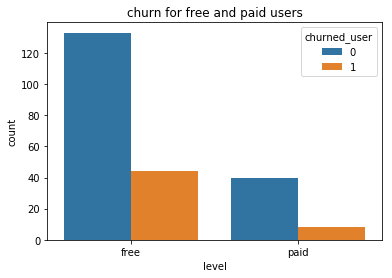

In [21]:
# explore the relation of churn to paid and free users
churn_per_level = df.dropDuplicates(['userId']).groupBy("churned_user", "level").count().toPandas()
sns.barplot(x='level', y='count', hue='churned_user', data=churn_per_level)
plt.title('churn for free and paid users')
plt.show()

In [22]:
# ratio of churned users to total users, per level
df.dropDuplicates(['userId']).select('level', 'churned_user').groupby('level').agg(F.sum('churned_user') / F.count('level')).show()

+-----+----------------------------------+
|level|(sum(churned_user) / count(level))|
+-----+----------------------------------+
| free|               0.24858757062146894|
| paid|               0.16666666666666666|
+-----+----------------------------------+



In [23]:
# gender distribution of users
df.dropDuplicates(['userId']).groupBy('gender').count().show()

+------+-----+
|gender|count|
+------+-----+
|     F|  104|
|     M|  121|
+------+-----+



In [24]:
# user churn per gender
df.dropDuplicates(['userId']).groupBy('gender', 'churned_user').count().sort('gender').show()

+------+------------+-----+
|gender|churned_user|count|
+------+------------+-----+
|     F|           1|   20|
|     F|           0|   84|
|     M|           1|   32|
|     M|           0|   89|
+------+------------+-----+



In [25]:
# explore userAgent col to see if it stores any useful information for our analysis
df.describe('userAgent').show()

+-------+--------------------+
|summary|           userAgent|
+-------+--------------------+
|  count|              278154|
|   mean|                null|
| stddev|                null|
|    min|"Mozilla/5.0 (Mac...|
|    max|Mozilla/5.0 (comp...|
+-------+--------------------+



In [26]:
# explore auth column
df.select('auth').dropDuplicates().show()

+---------+
|     auth|
+---------+
|Cancelled|
|Logged In|
+---------+



In [27]:
# explore method column
df.select('method').dropDuplicates().show()

+------+
|method|
+------+
|   PUT|
|   GET|
+------+



In [28]:
# explore status column
df.select('status').dropDuplicates().show()

+------+
|status|
+------+
|   307|
|   404|
|   200|
+------+



In [29]:
# explore the distribution of status
# a high rate of 404 errors could indicate that the service is not working properly
df.groupby('status').count().show()

+------+------+
|status| count|
+------+------+
|   307| 23184|
|   404|   252|
|   200|254718|
+------+------+



In [30]:
# get an overview of the possible events
# save the list for further use
events = df.select('page').dropDuplicates()
events.show(30, False)

+-------------------------+
|page                     |
+-------------------------+
|Cancel                   |
|Submit Downgrade         |
|Thumbs Down              |
|Home                     |
|Downgrade                |
|Roll Advert              |
|Logout                   |
|Save Settings            |
|Cancellation Confirmation|
|About                    |
|Settings                 |
|Add to Playlist          |
|Add Friend               |
|NextSong                 |
|Thumbs Up                |
|Help                     |
|Upgrade                  |
|Error                    |
|Submit Upgrade           |
+-------------------------+



In [31]:
# explore the event distribution 
df.groupby('churned_user', 'page').count().sort('count', ascending=False).show(30, False)

+------------+---------------+------+
|churned_user|page           |count |
+------------+---------------+------+
|0           |NextSong       |191714|
|1           |NextSong       |36394 |
|0           |Thumbs Up      |10692 |
|0           |Home           |8410  |
|0           |Add to Playlist|5488  |
|0           |Add Friend     |3641  |
|0           |Roll Advert    |2966  |
|0           |Logout         |2673  |
|0           |Thumbs Down    |2050  |
|1           |Thumbs Up      |1859  |
|0           |Downgrade      |1718  |
|1           |Home           |1672  |
|0           |Settings       |1244  |
|0           |Help           |1215  |
|1           |Add to Playlist|1038  |
|1           |Roll Advert    |967   |
|1           |Add Friend     |636   |
|1           |Logout         |553   |
|1           |Thumbs Down    |496   |
|0           |About          |439   |
|0           |Upgrade        |387   |
|1           |Downgrade      |337   |
|1           |Settings       |270   |
|0          

In [32]:
# create ts column in seconds from the ts column in miliseconds
df = df.withColumn('ts_sec', col("ts")/1000.0)

In [33]:
# create human readable date field from the timestamp
df = df.withColumn('date', F.from_unixtime(col("ts_sec")))
df.show(5)

+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+---------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+------------+-------------+-------------------+
|              artist|     auth|firstName|gender|itemInSession| lastName|   length|level|            location|method|     page| registration|sessionId|                song|status|           ts|           userAgent|userId|churn|churned_user|       ts_sec|               date|
+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+---------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+------------+-------------+-------------------+
|Sleeping With Sirens|Logged In| Darianna|     F|            0|Carpenter|202.97098| free|Bridgeport-Stamfo...|   PUT| NextSong|1538016340000|       31|Captain Tyin Knot...|   

In [34]:
# in order to explore usage behavior we want to extract hour from the timestamp
# as well as the day and weekday the entry occured and save them as new columns for further use
get_hour = udf(lambda x: datetime.fromtimestamp(x).hour)
df = df.withColumn('hour', get_hour(df.ts_sec).cast(IntegerType()))

get_day = udf(lambda x: datetime.fromtimestamp(x).day)
df = df.withColumn('day', get_day(df.ts_sec).cast(IntegerType()))

get_weekday = udf(lambda x: datetime.fromtimestamp(x).isoweekday())
df = df.withColumn('weekday', get_weekday(df.ts_sec).cast(IntegerType()))

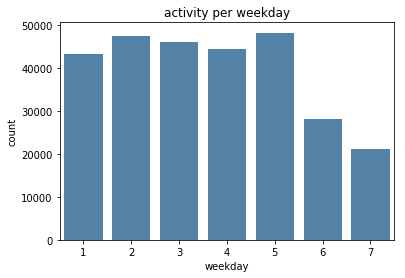

In [35]:
# the number of events happening per day could be an indication for intensity of use
# therefore we want to take a look at the usage distribution around the weekdays
activity_per_weekday_pd = df.select('weekday').groupBy('weekday').count().orderBy('weekday').toPandas()
sns.barplot(x='weekday', y='count', data=activity_per_weekday_pd, color='steelblue')
plt.title('activity per weekday')
plt.show()

If we assume that the number of events occuring is an indicator for usage, we can see that during the working week usage is nearly doubled compared to weekends. For comparison we can take a look at how the churn numbers are distributed among those days.

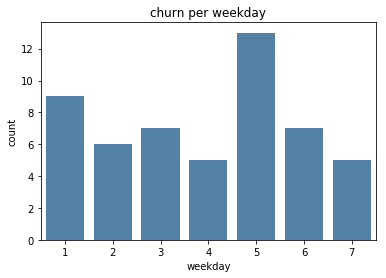

In [36]:
# look at the churn events per weekday
churn_weekday = df.select('weekday').where(df.churn == 1).groupBy('weekday').count().orderBy('weekday').toPandas()
sns.barplot(x='weekday', y='count', data=churn_weekday, color='steelblue')
plt.title('churn per weekday')
plt.show()

We can see that the usage pattern for overall activity can not be observed for the churn rate.

In [37]:
# get a sample of the number of songs users have listened to
df.select('userId','song').groupBy('userID').count().show(5)

+------+-----+
|userID|count|
+------+-----+
|100010|  381|
|200002|  474|
|   125|   11|
|    51| 2464|
|   124| 4825|
+------+-----+
only showing top 5 rows



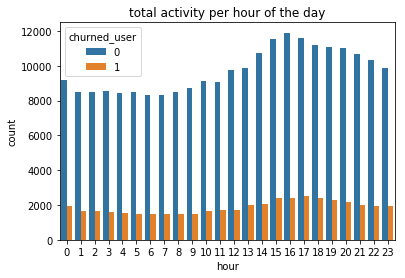

In [38]:
# get a sample of the activity on the plattform per hour of the day
activity_per_hour = df.groupBy('churned_user', 'hour').count().sort('hour').toPandas()
sns.barplot(x='hour', y='count', hue="churned_user", data=activity_per_hour)
plt.title('total activity per hour of the day')
plt.show()

In [39]:
# see last actions before churn for a specific user
df.select('userId', 'page', 'ts_sec', 'date').filter('userId = 17').orderBy('ts', ascending=False).show()

+------+--------------------+-------------+-------------------+
|userId|                page|       ts_sec|               date|
+------+--------------------+-------------+-------------------+
|    17|Cancellation Conf...|1.539465584E9|2018-10-13 21:19:44|
|    17|              Cancel|1.539465451E9|2018-10-13 21:17:31|
|    17|            Settings| 1.53946545E9|2018-10-13 21:17:30|
|    17|            NextSong|1.539464966E9|2018-10-13 21:09:26|
|    17|            NextSong|1.539464599E9|2018-10-13 21:03:19|
|    17|            NextSong|1.539464344E9|2018-10-13 20:59:04|
|    17|            NextSong|1.539464177E9|2018-10-13 20:56:17|
|    17|            NextSong|1.539463829E9|2018-10-13 20:50:29|
|    17|            NextSong|1.539463637E9|2018-10-13 20:47:17|
|    17|     Add to Playlist|1.539463579E9|2018-10-13 20:46:19|
|    17|            NextSong|1.539463374E9|2018-10-13 20:42:54|
|    17|            NextSong| 1.53946313E9|2018-10-13 20:38:50|
|    17|            NextSong|1.539462954

In [40]:
# create column with last found date per user
df = df.withColumn('last_date', F.max(col('date')).over(window_uid))
df.select('userId', 'page', 'ts', 'date', 'ts_sec', 'last_date').filter('userId = 123').orderBy('ts', ascending=False).show()

+------+-----------+-------------+-------------------+-------------+-------------------+
|userId|       page|           ts|               date|       ts_sec|          last_date|
+------+-----------+-------------+-------------------+-------------+-------------------+
|   123|     Logout|1543027386000|2018-11-24 02:43:06|1.543027386E9|2018-11-24 02:43:06|
|   123|   NextSong|1543027385000|2018-11-24 02:43:05|1.543027385E9|2018-11-24 02:43:06|
|   123|   NextSong|1543027132000|2018-11-24 02:38:52|1.543027132E9|2018-11-24 02:43:06|
|   123|   NextSong|1543026890000|2018-11-24 02:34:50| 1.54302689E9|2018-11-24 02:43:06|
|   123|   NextSong|1543026610000|2018-11-24 02:30:10| 1.54302661E9|2018-11-24 02:43:06|
|   123|Roll Advert|1543026292000|2018-11-24 02:24:52|1.543026292E9|2018-11-24 02:43:06|
|   123|   NextSong|1543026286000|2018-11-24 02:24:46|1.543026286E9|2018-11-24 02:43:06|
|   123|   NextSong|1543025980000|2018-11-24 02:19:40| 1.54302598E9|2018-11-24 02:43:06|
|   123|  Thumbs Up|1

In [42]:
# mark rows of last week for further use
df = df.withColumn('is_last_week', F.when(F.datediff(col('last_date'), col('date')) < 7, 1).otherwise(0))

In [43]:
# get page count for the last week
df = df.withColumn('page_sum_last_week', F.sum(col('is_last_week')).over(window_uid).alias("page_sum_last_week"))

In [44]:
# count the days in last week where entries are in the dataframe
days_last_week = df.groupBy('userId', 'is_last_week').agg(F.countDistinct('day').alias('days_last_week')).filter('is_last_week = 1')
df = df.join(days_last_week.select(['userId', 'days_last_week']), on='userId', how='left_outer')

In [45]:
# calculate the average pages per used day for the last week
df = df.withColumn('page_avg_last_week', col('page_sum_last_week') / col('days_last_week'))

In [46]:
# create a date column resembling only the days
df = df.withColumn('date_day', F.to_date('date','yyyy-MM-dd HH:mm:ss'))

In [47]:
# total pages per user for further use
df = df.withColumn('total_pages', F.count(col('userId')).over(window_uid))

In [48]:
# calculate the average pages a user visits per day
avg_page_per_day = df.groupBy('userId').agg((F.count('page') / F.countDistinct('date_day')).alias('avg_page_per_day'))
df = df.join(avg_page_per_day, on='userId', how='left_outer')

In [52]:
# ts active is the timespan where user actions are observable
# we suspect long term useres are less likely to churn
df = df.withColumn('ts_active', (F.max(col('ts')).over(window_uid) - F.min(col('ts')).over(window_uid))/86400000)
df.show(5)

+------+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+---------+-------------+---------+--------------------+------+-------------+--------------------+-----+------------+-------------+-------------------+----+---+-------+-------------------+------------+------------------+--------------+------------------+----------+-----------+-----------------+-----------------+
|userId|              artist|     auth|firstName|gender|itemInSession| lastName|   length|level|            location|method|     page| registration|sessionId|                song|status|           ts|           userAgent|churn|churned_user|       ts_sec|               date|hour|day|weekday|          last_date|is_last_week|page_sum_last_week|days_last_week|page_avg_last_week|  date_day|total_pages| avg_page_per_day|        ts_active|
+------+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+--

# Feature Engineering

In [53]:
# take a look at the scheme once again and choose relevant existing features for the model
df.printSchema()

root
 |-- userId: string (nullable = true)
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- churn: integer (nullable = true)
 |-- churned_user: integer (nullable = true)
 |-- ts_sec: double (nullable = true)
 |-- date: string (nullable = true)
 |-- hour: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- weekday: integer (nullable = true)
 |-- last_date: string (nullable = t

In [54]:
# generate a user based dataframe where each row represents a user and each col a feature
# retain only the features relevant for the model or further feature engineering
df_feature = df.groupBy('userId').agg(F.first('gender').alias('gender'), \
                                      F.first('churned_user').alias('churned_user'), \
                                      F.first('total_pages').alias('total_pages'), \
                                      F.first('ts_active').alias('ts_active'))

In [55]:
# doublecheck if the new dataframe was generated correctly
df_feature.show(5)

+------+------+------------+-----------+-------------------+
|userId|gender|churned_user|total_pages|          ts_active|
+------+------+------------+-----------+-------------------+
|100010|     F|           0|        381|  44.21780092592593|
|200002|     M|           0|        474| 45.496805555555554|
|   125|     M|           1|         11|0.02053240740740741|
|   124|     F|           0|       4825| 59.996944444444445|
|    51|     M|           1|       2464| 15.779398148148148|
+------+------+------------+-----------+-------------------+
only showing top 5 rows



In [56]:
# create function that returns 1 if gender is female and 0 is male
encode_gender = udf(lambda x: 1 if x == 'F' else 0, IntegerType())

In [57]:
# encode gender column
df_feature = df_feature.withColumn('gender', encode_gender('gender'))
df_feature.show(5)

+------+------+------------+-----------+-------------------+
|userId|gender|churned_user|total_pages|          ts_active|
+------+------+------------+-----------+-------------------+
|100010|     1|           0|        381|  44.21780092592593|
|200002|     0|           0|        474| 45.496805555555554|
|   125|     0|           1|         11|0.02053240740740741|
|   124|     1|           0|       4825| 59.996944444444445|
|    51|     0|           1|       2464| 15.779398148148148|
+------+------+------------+-----------+-------------------+
only showing top 5 rows



In [58]:
# calculate thumbs up ratio and add them as a new column
thumbs_up_ratio = df.filter(col('page') == 'Thumbs Up').groupBy('userId').agg((count(col('page')) / F.first('total_pages')).alias('thumbs_up_ratio'))
df_feature = df_feature.join(thumbs_up_ratio, on='userId', how='inner')

In [59]:
# calculate thumbs down ratio and add them as a new column
thumbs_down_ratio = df.filter(col('page') == 'Thumbs Down').groupBy('userId').agg((count(col('page')) / F.first('total_pages')).alias('thumbs_down_ratio'))
df_feature = df_feature.join(thumbs_down_ratio, on='userId', how='inner')

In [60]:
# we assume that users are more likely to churn if they have problems using the service
# how often they use the help page in relation to total pages is our corresponding indicator
page_help = df.filter(df['page'] == 'Help').groupby('userId').count().withColumnRenamed('count', 'help')
df_feature = df_feature.join(page_help, on='userId', how='inner')

df_feature = df_feature.withColumn('help_ratio', col('help') / col('total_pages'))
df_feature.show(5)

+------+------+------------+-----------+------------------+--------------------+--------------------+----+--------------------+
|userId|gender|churned_user|total_pages|         ts_active|     thumbs_up_ratio|   thumbs_down_ratio|help|          help_ratio|
+------+------+------------+-----------+------------------+--------------------+--------------------+----+--------------------+
|100010|     1|           0|        381| 44.21780092592593| 0.04461942257217848|0.013123359580052493|   2|0.005249343832020997|
|200002|     0|           0|        474|45.496805555555554| 0.04430379746835443|0.012658227848101266|   2|0.004219409282700422|
|   124|     1|           0|       4825|59.996944444444445| 0.03544041450777202| 0.00849740932642487|  23|0.004766839378238342|
|    51|     0|           1|       2464|15.779398148148148|0.040584415584415584|0.008522727272727272|  12| 0.00487012987012987|
|     7|     0|           0|        201|50.784050925925925| 0.03482587064676617|0.004975124378109453|   

In [61]:
# we assume that users are less likely to churn if a lot of their friends use the service
# add friend is used as an indicator for friend engagement
add_friend = df.filter(df['page'] == 'Add Friend').groupby('userId').count().withColumnRenamed('count', 'add_friend')
df_feature = df_feature.join(add_friend, on='userId', how='inner')
df_feature.show(5)

+------+------+------------+-----------+------------------+--------------------+--------------------+----+--------------------+----------+
|userId|gender|churned_user|total_pages|         ts_active|     thumbs_up_ratio|   thumbs_down_ratio|help|          help_ratio|add_friend|
+------+------+------------+-----------+------------------+--------------------+--------------------+----+--------------------+----------+
|100010|     1|           0|        381| 44.21780092592593| 0.04461942257217848|0.013123359580052493|   2|0.005249343832020997|         4|
|200002|     0|           0|        474|45.496805555555554| 0.04430379746835443|0.012658227848101266|   2|0.004219409282700422|         4|
|   124|     1|           0|       4825|59.996944444444445| 0.03544041450777202| 0.00849740932642487|  23|0.004766839378238342|        74|
|    51|     0|           1|       2464|15.779398148148148|0.040584415584415584|0.008522727272727272|  12| 0.00487012987012987|        28|
|     7|     0|           0

In [62]:
# adverts over timespan
roll_advert = df.filter(df['page'] == 'Roll Advert').groupby('userId').count().withColumnRenamed('count', 'roll_advert')
df_feature = df_feature.join(roll_advert, on='userId', how='inner')
df_feature = df_feature.withColumn('advert_ts', col('roll_advert') / col('ts_active'))
df_feature.show(5)

+------+------+------------+-----------+------------------+-------------------+--------------------+----+--------------------+----------+-----------+--------------------+
|userId|gender|churned_user|total_pages|         ts_active|    thumbs_up_ratio|   thumbs_down_ratio|help|          help_ratio|add_friend|roll_advert|           advert_ts|
+------+------+------------+-----------+------------------+-------------------+--------------------+----+--------------------+----------+-----------+--------------------+
|100010|     1|           0|        381| 44.21780092592593|0.04461942257217848|0.013123359580052493|   2|0.005249343832020997|         4|         52|  1.1759969720590784|
|200002|     0|           0|        474|45.496805555555554|0.04430379746835443|0.012658227848101266|   2|0.004219409282700422|         4|          7| 0.15385695576917793|
|   124|     1|           0|       4825|59.996944444444445|0.03544041450777202| 0.00849740932642487|  23|0.004766839378238342|        74|        

In [63]:
# next song last week
next_lw = df.filter((col('page') == 'NextSong') & (col('is_last_week') == 1)).groupBy('userId').count().withColumnRenamed('count', 'next_lw')
next_lw = next_lw.withColumn("next_lw", next_lw["next_lw"].cast(IntegerType()))
df_feature = df_feature.join(next_lw, on='userId', how='inner')
df_feature.show(5)

+------+------+------------+-----------+------------------+-------------------+--------------------+----+--------------------+----------+-----------+--------------------+-------+
|userId|gender|churned_user|total_pages|         ts_active|    thumbs_up_ratio|   thumbs_down_ratio|help|          help_ratio|add_friend|roll_advert|           advert_ts|next_lw|
+------+------+------------+-----------+------------------+-------------------+--------------------+----+--------------------+----------+-----------+--------------------+-------+
|100010|     1|           0|        381| 44.21780092592593|0.04461942257217848|0.013123359580052493|   2|0.005249343832020997|         4|         52|  1.1759969720590784|     24|
|200002|     0|           0|        474|45.496805555555554|0.04430379746835443|0.012658227848101266|   2|0.004219409282700422|         4|          7| 0.15385695576917793|    120|
|   124|     1|           0|       4825|59.996944444444445|0.03544041450777202| 0.00849740932642487|  23|

In [64]:
# thumbs down last week
thumbs_down_lw = df.filter((col('page') == 'Thumbs Down') & (col('is_last_week') == 1)).groupBy('userId').count().withColumnRenamed('count', 'thumbs_down_lw')
df_feature = df_feature.join(thumbs_down_lw, on='userId', how='inner')
df_feature.show(5)

+------+------+------------+-----------+------------------+-------------------+--------------------+----+--------------------+----------+-----------+--------------------+-------+--------------+
|userId|gender|churned_user|total_pages|         ts_active|    thumbs_up_ratio|   thumbs_down_ratio|help|          help_ratio|add_friend|roll_advert|           advert_ts|next_lw|thumbs_down_lw|
+------+------+------------+-----------+------------------+-------------------+--------------------+----+--------------------+----------+-----------+--------------------+-------+--------------+
|100010|     1|           0|        381| 44.21780092592593|0.04461942257217848|0.013123359580052493|   2|0.005249343832020997|         4|         52|  1.1759969720590784|     24|             1|
|   124|     1|           0|       4825|59.996944444444445|0.03544041450777202| 0.00849740932642487|  23|0.004766839378238342|        74|          4| 0.06667006190130052|    216|             1|
|    15|     0|           0|  

In [65]:
# unperstist the df dataframe to free up memory
df.unpersist()

DataFrame[userId: string, artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, churn: int, churned_user: int, ts_sec: double, date: string, hour: int, day: int, weekday: int, last_date: string, is_last_week: int, page_sum_last_week: bigint, days_last_week: bigint, page_avg_last_week: double, date_day: date, total_pages: bigint, avg_page_per_day: double, ts_active: double]

In [66]:
# look at the final feature dataframe usable by the models
df_feature.printSchema()

root
 |-- userId: string (nullable = true)
 |-- gender: integer (nullable = true)
 |-- churned_user: integer (nullable = true)
 |-- total_pages: long (nullable = true)
 |-- ts_active: double (nullable = true)
 |-- thumbs_up_ratio: double (nullable = true)
 |-- thumbs_down_ratio: double (nullable = true)
 |-- help: long (nullable = false)
 |-- help_ratio: double (nullable = true)
 |-- add_friend: long (nullable = false)
 |-- roll_advert: long (nullable = false)
 |-- advert_ts: double (nullable = true)
 |-- next_lw: integer (nullable = false)
 |-- thumbs_down_lw: long (nullable = false)



# Modeling

In [67]:
# rename the 'churned_user' column to 'label' in order to be usable by the ML models
df_feature = df_feature.withColumnRenamed('churned_user', 'label')

# split set into test and train data
train, test = df_feature.randomSplit([0.8, 0.2], seed=17)

**Define pipeline components**

In [68]:
# classify the features into categories to differntiate further processing
numeric_features = ['thumbs_up_ratio', 'thumbs_down_ratio', 'add_friend', 'help_ratio', 'ts_active', 'advert_ts', 'thumbs_down_lw', 'next_lw']
binary_features = ['gender']

# create numeric feature vector for further standardization
assembler_numeric = VectorAssembler(inputCols=numeric_features, outputCol="numeric_features_vector")

# scale numeric cols
scaler = StandardScaler(inputCol="numeric_features_vector", outputCol="scaled_numeric_features", withStd=True, withMean=True)

# create feature vector
assembler = VectorAssembler(inputCols=['scaled_numeric_features']+binary_features, outputCol="features")

In [69]:
def get_cv_results(model_crossval_object):
    """
    get the auc scores of a crossvalidation grid
    
    INPUT:
    model_crossval_object - fitted crossvalidation object
            
    OUTPUT:
    dataframe - with params of the crosvalidator and the corresponding AUC score   
    
    inspired by: https://stackoverflow.com/questions/51230726/extract-results-from-crossvalidator-with-paramgrid-in-pyspark
    """
    params = [{p.name: v for p, v in m.items()} for m in model_crossval_object.getEstimatorParamMaps()]
    auc_scores = model_crossval_object.avgMetrics
    
    cv_results = pd.DataFrame(params)
    cv_results['AUC score'] = auc_scores

    return cv_results

In [70]:
def get_model_evaluation(results):
    """
    evaluate the model based on predictions on the test data
    
    INPUT:
    results - results of the model with test data
            
    OUTPUT:
    dict containing AUC score, F1 score and ratio of correct predictions on the test data
    """
    eval_dict = {}
    
    # AUC score to evaluate the results on the test data
    eval_dict['AUC score'] = BinaryClassificationEvaluator().evaluate(results)
    
    # f1 score to evaluate the results on the test data
    eval_dict['F1 score'] = MulticlassClassificationEvaluator(metricName='f1').evaluate(results)
    
    # calcualte the ratio of correct predictions
    eval_dict['Correct prediction ratio'] = \
    results.filter(results.label == results.prediction).count() / results.count()
    
    return eval_dict

In [71]:
# create model evaluation dict
model_evaluation = {
    'logistic regression': {},
    'gbt': {}
}

**logistic regression**

In [72]:
# create model
lr = LogisticRegression()
lr_pipeline = Pipeline(stages=[assembler_numeric, scaler, assembler, lr])

In [73]:
# parameter grid for model tuning
# Always trying out extreme values first in the param grid to see how the model reacts 
lr_paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam,[0.0, 0.1]) \
    .addGrid(lr.maxIter, [10, 20]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.2]) \
    .build()

# crossvalidator for 2-fold cross-validation
lr_crossval = CrossValidator(estimator=lr_pipeline,
                          estimatorParamMaps=lr_paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=2)

In [74]:
# fit the model
lr_model_crossval = lr_crossval.fit(train)

In [75]:
# show grid search results
get_cv_results(lr_model_crossval)

,elasticNetParam,maxIter,regParam,AUC score
0,0.0,10,0.0,0.804824
1,0.2,10,0.0,0.804824
2,0.0,20,0.0,0.802952
3,0.2,20,0.0,0.802952
4,0.0,10,0.1,0.846913
5,0.2,10,0.1,0.873363
6,0.0,20,0.1,0.846913
7,0.2,20,0.1,0.873363


In [76]:
# transformer of cross validator applies the best performing pipeline by default
lr_results = lr_model_crossval.transform(test)

In [77]:
# evaluate results
model_evaluation['logistic regression'] = get_model_evaluation(lr_results)

In [78]:
# evaluate results on the test data
model_evaluation['logistic regression']

{'AUC score': 0.9629629629629629,
 'F1 score': 0.7083333333333333,
 'Correct prediction ratio': 0.75}

**Gradient-boosted tree**

In [79]:
gb = GBTClassifier()
gb_pipeline = Pipeline(stages = [assembler_numeric, scaler, assembler, gb])

In [80]:
# parameter grid for model tuning
# Always trying out extreme values first in the param grid to see how the model reacts 
gb_paramGrid = ParamGridBuilder() \
    .addGrid(gb.maxDepth, [4, 8]) \
    .addGrid(gb.maxIter, [5, 20]) \
    .build()

# crossvalidator for 2-fold cross-validation
gb_crossval = CrossValidator(estimator = gb_pipeline,
                          estimatorParamMaps = gb_paramGrid,
                          evaluator = BinaryClassificationEvaluator(),
                          numFolds = 2)

In [81]:
# fit the model
gb_model_crossval = gb_crossval.fit(train)

In [82]:
# show grid search results
get_cv_results(gb_model_crossval)

,maxDepth,maxIter,AUC score
0,4,5,0.806432
1,4,20,0.808515
2,8,5,0.806432
3,8,20,0.808515


In [83]:
# show feature importance to see how the model is structured
gb_importance = gb_model_crossval.bestModel.stages[-1].featureImportances
feature_names = ['thumbs_up_ratio', 'thumbs_down_ratio', 'add_friend', 'help_ratio', 'ts_active', 'thumbs_down_lw', 'advert_ts', 'next_lw', 'gender']

pd.DataFrame({"feature": feature_names, "importance": gb_importance})

,feature,importance
0,thumbs_up_ratio,0.225154
1,thumbs_down_ratio,0.105197
2,add_friend,0.080114
3,help_ratio,0.091796
4,ts_active,0.376416
5,thumbs_down_lw,0.045305
6,advert_ts,0.032064
7,next_lw,0.043953
8,gender,0.000000


In [84]:
# transformer of cross validator applies the best performing pipeline by default
gb_results = gb_model_crossval.transform(test)

In [85]:
# evaluate results on the test data
model_evaluation['gbt'] = get_model_evaluation(gb_results)
model_evaluation['gbt']

{'AUC score': 0.9111111111111111,
 'F1 score': 0.7664835164835164,
 'Correct prediction ratio': 0.7916666666666666}

**Final results**

In [86]:
# compare the evaluation metrics the implemented classifiers produced on the test data
pd.DataFrame(model_evaluation).transpose()

,AUC score,Correct prediction ratio,F1 score
logistic regression,0.962963,0.750000,0.708333
gbt,0.911111,0.791667,0.766484
